## Process
### Start Bullet Server with ControlHubPlugin
#### windows
```cmd
rnb-control\BulletSimControl\x64\Release\BulletSimControl.exe
```
#### linux
```bash
rnb-control/BulletSimControl/bin/BulletSimControl
```

In [1]:
from bullet_sim_client import *
from utils.trajectory_client.trajectory_client import TrajectoryClient
from utils.web_client import WebClient

## Connect and set physics

In [2]:
init_bullet_sim()

## Test Controller in ControlHub

### load robots and initialize control hub

In [11]:
ROBOT_TYPE = RobotType.KUKA_IIWA
ROWS = 1
COLS = 5
UI_PORT_BASE = 9900
TRAJ_PORT_BASE = 9800
pc_mat = []
for i in range(ROWS):
    pc_list = []
    for j in range(COLS):
        pc = BulletControlHubClient(get_urdf_path(ROBOT_TYPE), 
                                    xyz=(i,j,0))
        pc.set_control_hub(ui_port=UI_PORT_BASE+i*COLS+j, 
                           traj_port=TRAJ_PORT_BASE+i*COLS+j) ## Init ControlHub
        pc_list.append(pc)
    pc_mat.append(pc_list)

### Initialize states

In [12]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
else:
    Q0 = [0, -np.pi / 8, 0, np.pi / 4,  0, -np.pi / 8, 0] # for iiwa
Q2 = np.add(Q0, np.pi/2)

for i in range(ROWS):
    for j in range(COLS):
        pc_mat[i][j].initialize_state(Q=Q0)

### Change gamma values

In [13]:
wc_mat = []
gamma_list = []
for i in range(ROWS):
    wc_list = []
    for j in range(COLS):
        wc = WebClient(ip='localhost', port=pc_mat[i][j].ui_port)
        gamma = round(((1.0+i*COLS+j)/(COLS*ROWS))**2, 4)
        wc.change_gain(Gamma0=gamma)
        gamma_list.append(gamma)
        wc_list.append(wc)
    wc_mat.append(wc_list)

URI sent: http://localhost:9900/param_setting?Gamma0=0.04
URI sent: http://localhost:9901/param_setting?Gamma0=0.16
URI sent: http://localhost:9902/param_setting?Gamma0=0.36
URI sent: http://localhost:9903/param_setting?Gamma0=0.64
URI sent: http://localhost:9904/param_setting?Gamma0=1.0


### Send motions

In [14]:
tc_mat = []
N_div = 50
for i in range(ROWS):
    tc_list = []
    for j in range(COLS):
        tc = TrajectoryClient("localhost", server_port=pc_mat[i][j].traj_port)
        tc.move_joint_s_curve(Q2, q0=Q0, N_div=N_div, 
                              start_tracking=False, auto_stop=False, 
                              wait_finish=False)
        tc.move_joint_s_curve(Q0, q0=Q2, N_div=N_div, 
                              start_tracking=False, auto_stop=False, 
                              wait_finish=False)
        tc.start_tracking()
        tc_list.append(tc)
    tc_mat.append(tc_list)

### Fast SImulation
* Non-realtime fast simulation

In [15]:
traj_time = (N_div*2)/tc.traj_freq
control_steps = traj_time/pc.DT
start_simulation_thread(realtime=False, step_num=control_steps*1.5) # Simulation ON

In [16]:
while not is_sim_stopped():
    time.sleep(0.1)

[INFO] simulation thread stopped


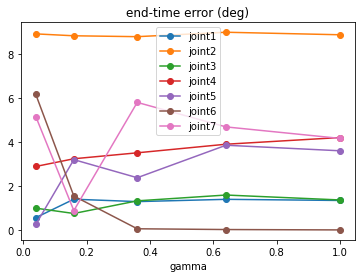

In [17]:
Qlist = []
for i in range(ROWS):
    for j in range(COLS):
        Qlist.append(tc_mat[i][j].get_qcur())
Qlist = np.array(Qlist)
plt.plot(gamma_list, np.abs(np.rad2deg(np.subtract(Qlist, Q0))), '-o')
plt.title("end-time error (deg)")
plt.xlabel("gamma")
plt.legend(["joint{}".format(i+1) for i in range(pc.joint_num)])

## Unload Robots

In [18]:
for i in range(ROWS):
    for j in range(COLS):
        pc_mat[i][j].unload()